The below code comes from [this](https://realpython.com/python-keras-text-classification/).

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [2]:
df_yelp = pd.read_csv("yelp_labelled.txt", names=['sentence', 'label'], sep="\t")
df_yelp.head()

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## Understand BOW (bag-of-words)

In [3]:
sentences = ['John likes ice cream', 'John hates John chocolate.', "Thi likes butter", "Thi hates chocolate."]

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0,
 'likes': 7,
 'ice': 6,
 'cream': 4,
 'hates': 5,
 'chocolate': 3,
 'Thi': 1,
 'butter': 2}

In [4]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 0, 0, 1, 0, 1, 1],
       [2, 0, 0, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 0]], dtype=int64)

In [7]:
sentences = ['John likes ice cream', 'John hates John chocolate.', "Thi likes butter", "Thi hates chocolate."]
from sklearn.feature_extraction.text import TfidfVectorizer  
tfidfconverter = TfidfVectorizer()  
X = tfidfconverter.fit_transform(sentences).toarray()
X

array([[0.        , 0.        , 0.55528266, 0.        , 0.55528266,
        0.43779123, 0.43779123, 0.        ],
       [0.        , 0.40824829, 0.        , 0.40824829, 0.        ,
        0.81649658, 0.        , 0.        ],
       [0.66767854, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.52640543, 0.52640543],
       [0.        , 0.57735027, 0.        , 0.57735027, 0.        ,
        0.        , 0.        , 0.57735027]])

## Back to our problem

In [37]:
sentences = df_yelp['sentence'].values # returns np array
y = df_yelp['label'].values

In [6]:
from sklearn.model_selection import train_test_split

In [38]:
sentences_train, sentences_test, y_train, y_test = train_test_split(
...    sentences, y, test_size=0.25, random_state=1000)

In [8]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [9]:
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

### Using Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy for df_yelp dataset:", score)

Accuracy for df_yelp dataset: 0.796


## Using 3 different datasets?

In [12]:
filepath_dict = {'yelp':   'yelp_labelled.txt',
                 'amazon': 'amazon_cells_labelled.txt',
                 'imdb':   'imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)

In [13]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


## Keras model

In [14]:
from keras.models import Sequential
from keras import layers

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
input_dim = X_train.shape[1]  # Number of features
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
model.compile(loss='binary_crossentropy', 
...               optimizer='adam', 
...               metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                25060     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train, epochs=100, verbose=False, validation_data=(X_test, y_test), batch_size=10)

Instructions for updating:
Use tf.cast instead.


In [21]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)

In [22]:
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 1.0000


In [23]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)

In [24]:
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7861


In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

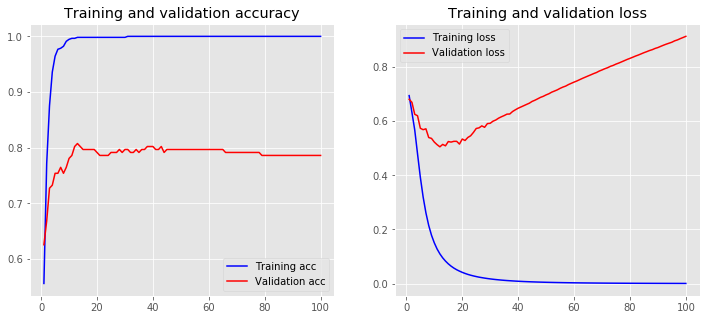

In [26]:
plot_history(history)

## Understanding One-Hot Encoding

In [27]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']
cities

['London', 'Berlin', 'Berlin', 'New York', 'London']

In [28]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 2, 1], dtype=int64)

In [29]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

## Understanding Word Embeddings

Their aim is to map semantic meaning into a geometric space. This geometric space is then called the embedding space.
This would map semantically similar words close on the embedding space like numbers or colors.

You can start by using the Tokenizer utility class which can vectorize a text corpus into a list of integers.

In [44]:
sentences = df_yelp['sentence'].values # returns np array
y = df_yelp['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [45]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000) # is responsible for setting the size of the vocabulary
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [46]:
print(sentences_train[2])

Of all the dishes, the salmon was the best, but all were great.


In [47]:
print(X_train[2])

[11, 43, 1, 171, 1, 283, 3, 1, 47, 26, 43, 24, 22]


In [48]:
# You can see the index of each word by taking a look at the word_index dictionary of the Tokenizer object:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 43
happy: 320
sad: 450


One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

Additionally you would want to add a maxlen parameter to specify how long the sequences should be. This cuts sequences that exceed that number. In the following code, you can see how to pad sequences with Keras:

In [49]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [50]:
print(X_train[0, :])

[  1  10   3 282 739  25   8 208  30  64 459 230  13   1 124   5 231   8
  58   5  67   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


## Keras Embedding Layer

In [51]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           87350     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 137,371
Trainable params: 137,371
Non-trainable params: 0
_________________________________________________________________


Train it

Training Accuracy: 1.0000
Testing Accuracy:  0.7440


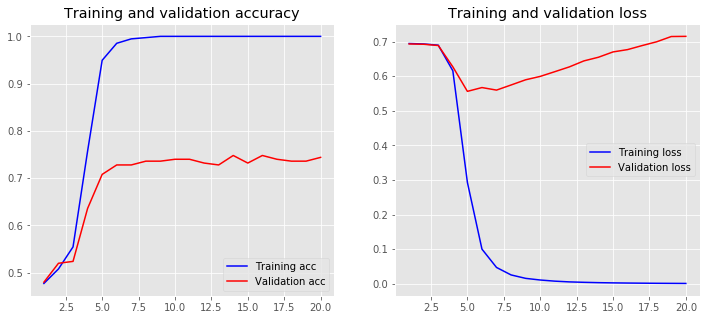

In [52]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Another way to work with embeddings is by using a MaxPooling1D/AveragePooling1D or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding. You can think of the pooling layers as a way to downsample (a way to reduce the size of) the incoming feature vectors.

In the case of max pooling you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model:

In [53]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Training Accuracy: 1.0000
Testing Accuracy:  0.8000


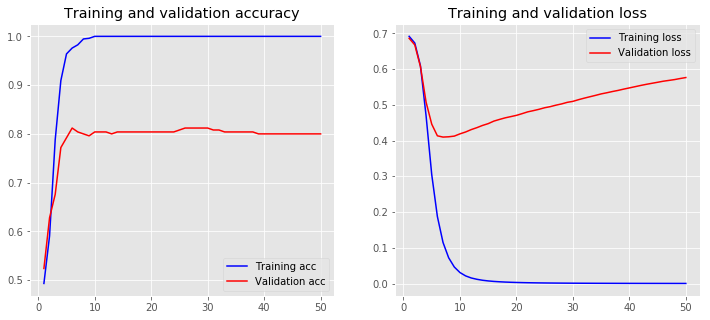

In [54]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)